In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [5]:
def txt_to_numpy(filename):
    a_file = open(filename)
    file_contents = a_file.read()
    contents_split = file_contents.splitlines()
    array=[]
    for i in range(len(contents_split)):
        array.append( np.array([x for x in contents_split[i].split(',')]))
    return np.array(array).astype(float)

In [6]:
#read in training dataset and labels
training_set=txt_to_numpy("handwriting_training_set.txt")
training_labels=txt_to_numpy("handwriting_training_set_labels.txt")
#read in test dataset and labels
test_set=txt_to_numpy("handwriting_test_set.txt")
test_labels=txt_to_numpy("handwriting_test_set_labels.txt")

Check Dimensions of read data 

In [7]:
print("Dimensions of training set:",np.shape(training_set))
print("Dimensions of training labels:",np.shape(training_labels))
print("Dimensions of test set:",np.shape(test_set))
print("Dimensions of test labels:",np.shape(test_labels))

Dimensions of training set: (4000, 400)
Dimensions of training labels: (4000, 1)
Dimensions of test set: (1000, 400)
Dimensions of test labels: (1000, 1)


Plotting a single entry in the data matrix 

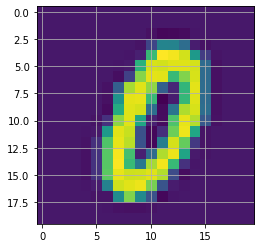

In [8]:
number=training_set[2]
number=np.reshape(number,(20,20)) 
plt.imshow(number.T, cmap=plt.get_cmap('viridis')) 
plt.grid();

Split the data matrices into ten distinct 400x400 matrices one for each digit 0-9

In [9]:
training_digits=np.split(training_set,10)
for i in range(10):
    training_digits[i]=training_digits[i].T
    

Compute SVD for each digit matrix and store the resulting decomposition in a respective Us,Ss,Vs, matrix for each access

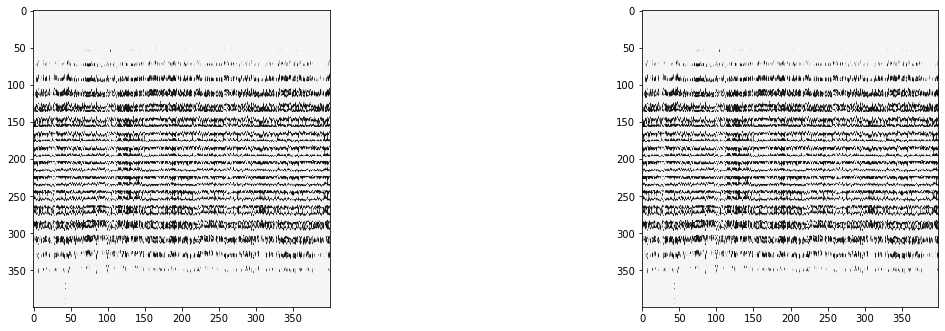

In [30]:
sample_digit=0
#Plot starting data for comparison to SVD reconstruction
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
plt.imshow(training_digits[sample_digit], cmap='Greys', interpolation='nearest')

#initialize lists for storing the decompositions for each digit matrix
L_singular_vectors=[]
Sigma_matrices=[]
R_singular_vectors=[]
 
#Compute the SVD fr each digit and store the resulting matrices that form the decomposition in a new matrix 
for i in range(10):
    #compute svd for the digit  i 
    u,s,v = la.svd(training_digits[i],full_matrices=False)
    L_singular_vectors.append(u.T)
    Sigma_matrices.append(s)# use np.diag(S) for nxn matrix of singular values 
    R_singular_vectors.append(v)
    
    
#conver the lists to numpy arrays after storing all of the decompositions
Us=np.array(L_singular_vectors).astype(float)
Ss=np.array(Sigma_matrices).astype(float)
Vs=np.array(R_singular_vectors).astype(float)

fig.add_subplot(2, 2, 2)
plt.imshow(Us[sample_digit].T*Ss[sample_digit]@Vs[sample_digit], cmap='Greys', interpolation='nearest')

Shape of U    : (10, 400, 400)
Shape of Sigma: (10, 400)
Shape of VT   : (10, 400, 400)


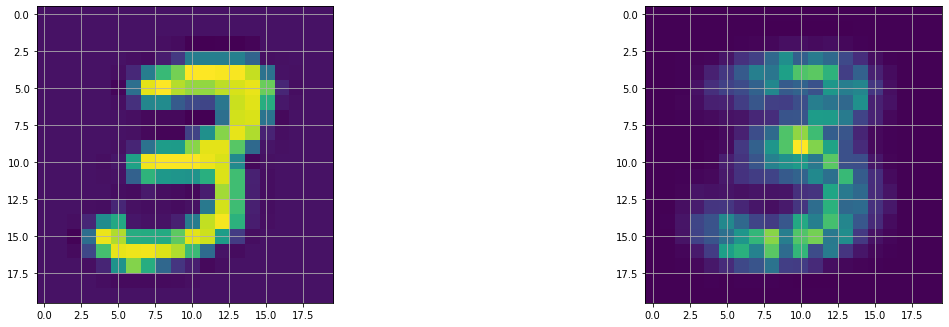

In [103]:
#This structure allows us to use nested indicies to reference parts of the various svds computed
# For instance the first unitary vector for digit 0 is Us[0][1] etc,

digit=3
sample=0
#print SVD dimensions
print("Shape of U    :",np.shape(Us))
print("Shape of Sigma:",np.shape(Ss))
print("Shape of VT   :",np.shape(Vs))


control=np.reshape(training_set[digit*400+sample],(20,20))

#PLOT test entry 
fig = plt.figure(figsize=(20, 12))
#plot
fig.add_subplot(2, 2, 1)
plt.imshow(control.T, cmap=plt.get_cmap('viridis')) 
plt.grid();

#compute svd reconstructed entry
data_test=Ss[digit][sample]*Us[digit][sample]*Vs[digit][sample]

data_test=np.reshape(data_test,(20,20))  
#PLOT
fig.add_subplot(2, 2, 2)
plt.grid();
plt.imshow(data_test.T, cmap=plt.get_cmap('viridis')) 

In [293]:
def classify_y(Us,y,singular_vectors):
    print(Us[0][:singular_vectors].shape)
    #print(y.reshape((400,1)).shape)
    #print(Us[0][:singular_vectors])
    #print(la.lstsq(Us[0][:singular_vectors].T,y))
    min_distance= la.norm(y-la.lstsq(Us[0][:singular_vectors].T,y)@Us[0][:singular_vectors].T)
    classification=10
    
    for i in range(1,10):
        if la.norm(y-la.lstsq(Us[i][:singular_vectors].T,y))<min_distance:
            min_distance=la.norm(y-la.lstq(Us[i][:singular_vectors].T,y))
            classification=i
            
    """
    beta=(la.solve(Us[0][:singular_vectors]@Us[0][:singular_vectors].T,Us[0][:singular_vectors]@y.reshape((400,1))))
    print(Us[0][:singular_vectors].shape)
    z0=y-(Us[0][:singular_vectors].T@beta.reshape((5,1)))
    min_distance =la.norm(z0)
    classification=10
    
    for i in range(1,10):
        beta=(la.solve(Us[i][:singular_vectors]@Us[i][:singular_vectors].T,Us[i][:singular_vectors]@y.reshape((400,1))))
        #print(Us[0][:singular_vectors].shape)
        #z0=y-(Us[0][:singular_vectors].T@beta.reshape((5,1)))
        zi=y-(Us[0][:singular_vectors].T@beta.reshape((5,1)))
        if la.norm(zi)<min_distance:
            min_distance=la.norm(zi)
            classification=i
    """        
    return classification

In [337]:
"""
def classify_y(Us,y,singular_vectors):
    min_val=float('inf')
    classification=0
    for i in range(10):
        xhat=la.lstsq(Us[i][:singular_vectors].T,y)
        print(xhat)
        print(np.asarray(xhat).shape)
        yhat=Us[i][:singular_vectors].T@xhat
        z=y-yhat
        if la.norm(z)<min_val:
            min_val=la.norm(z)
            classification=i
            """
            
def classify_y(Us, y, r):
    min_val = float('inf')
    classification = 0
    U_rs = [U[:r] for U in Us]
    for i,U_r in enumerate(U_rs):
        x_i = la.solve(U_r@U_r.T,U_r@y)
        diff = la.norm(y-U_r.T@x_i)
        if diff < min_val:
            min_val = diff
            if(i==0):
                classification=10
            else:
                classification = i
    #print(" ")
    return classification

In [351]:
def print_digit(y):
    fig = plt.figure(figsize=(20, 12))
    fig.add_subplot(2, 2, 1)
    plt.imshow(y.reshape(20,20).T, cmap=plt.get_cmap('viridis')) 
    plt.grid();
    plt.show()

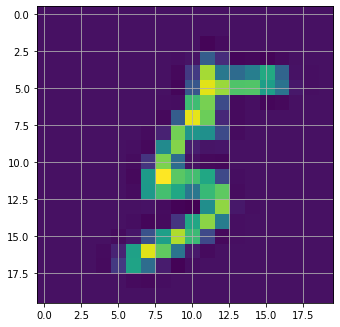

6 [5.]


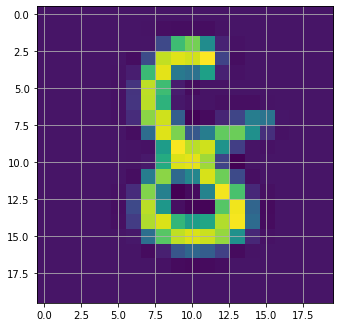

6 [8.]


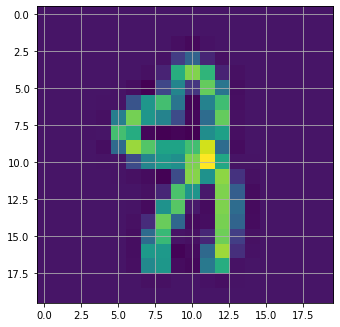

9 [8.]


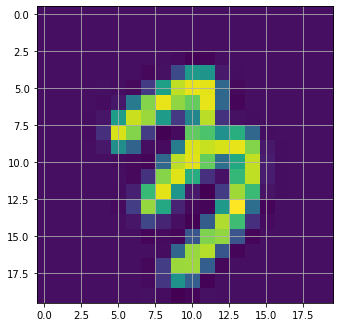

9 [3.]


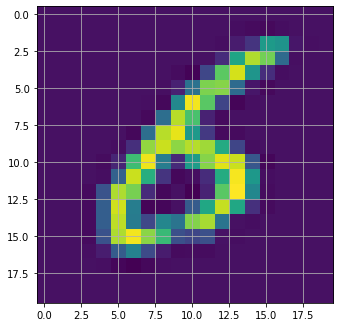

5 [6.]


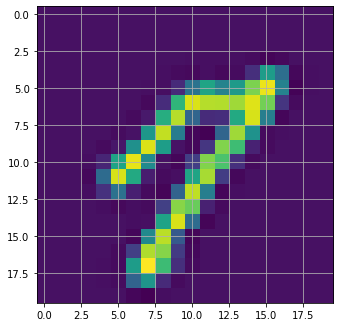

9 [7.]


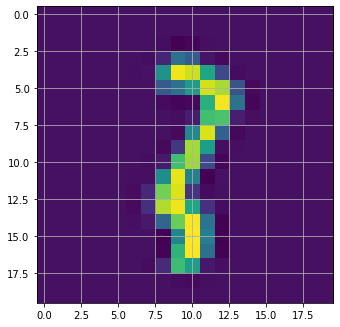

1 [3.]


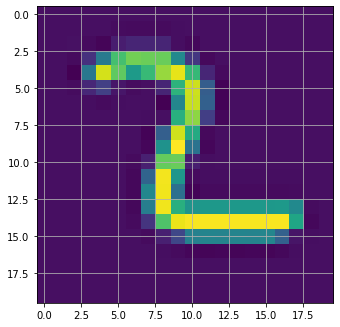

6 [2.]


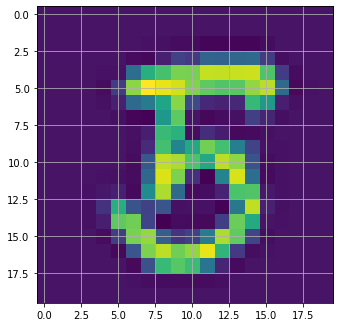

8 [5.]


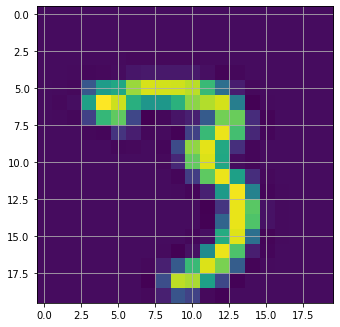

9 [3.]


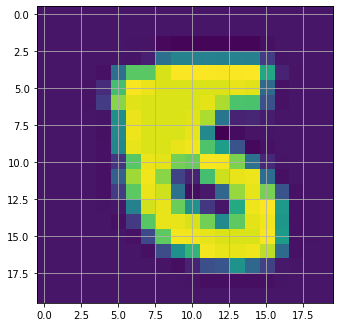

5 [8.]


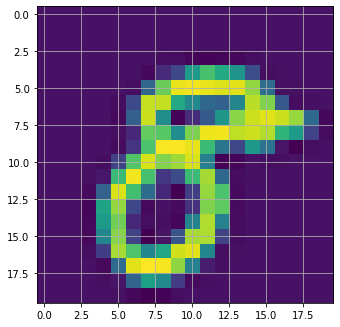

3 [8.]


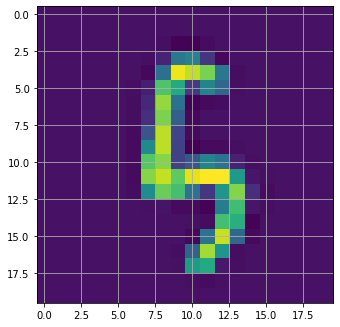

6 [5.]


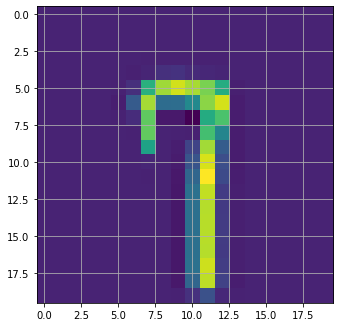

9 [7.]


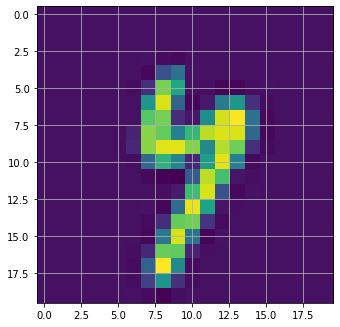

9 [4.]


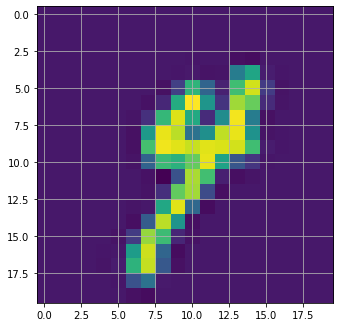

9 [4.]


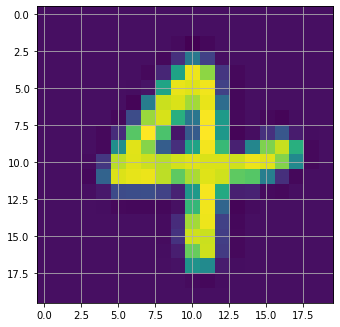

9 [4.]


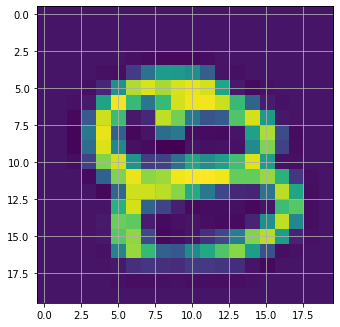

9 [8.]


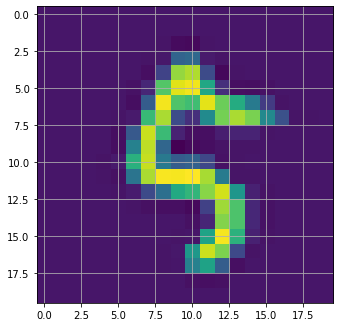

9 [5.]


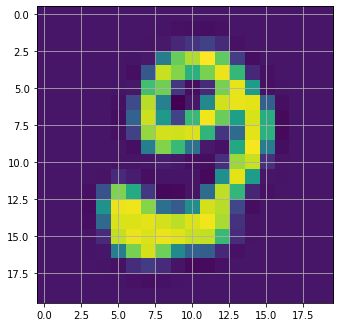

3 [2.]


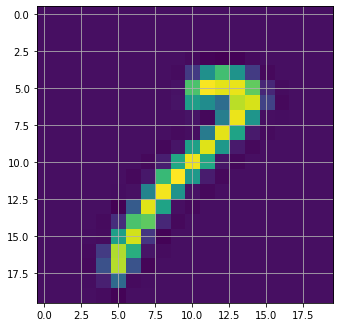

1 [7.]


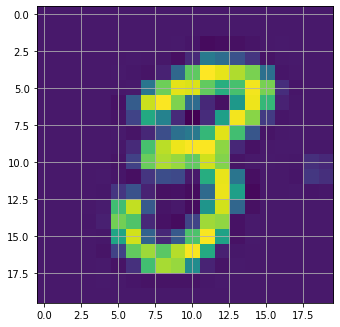

8 [3.]


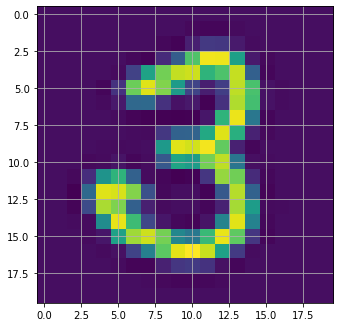

8 [3.]


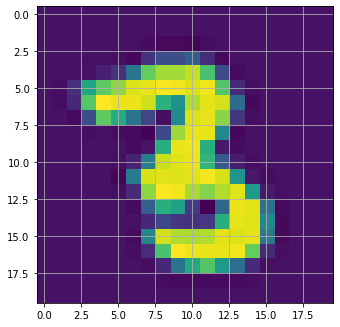

8 [3.]


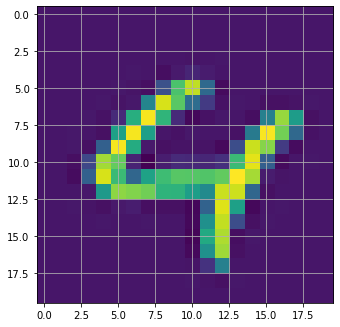

9 [4.]


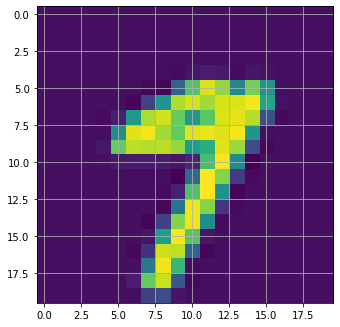

7 [9.]


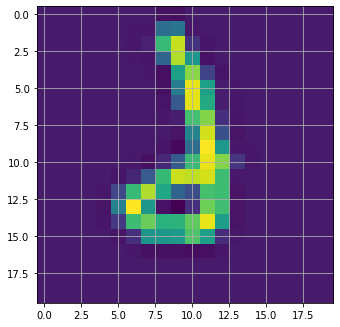

3 [2.]


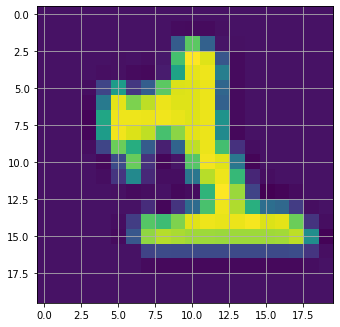

3 [1.]


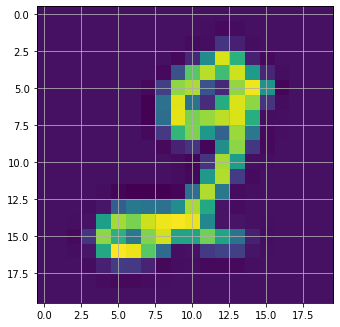

3 [2.]


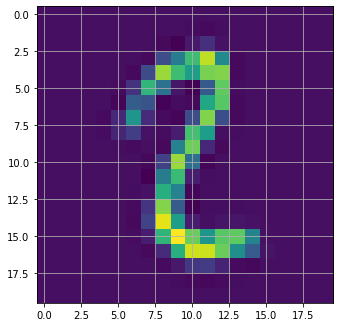

8 [2.]


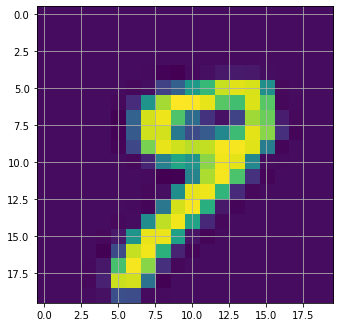

7 [9.]


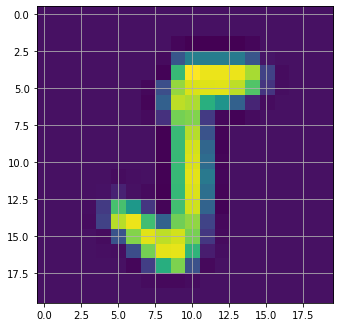

8 [5.]


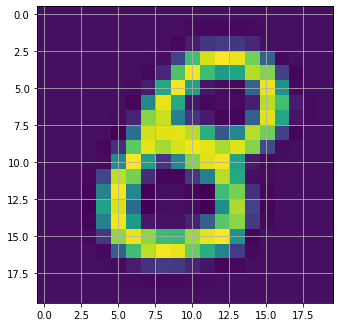

5 [8.]


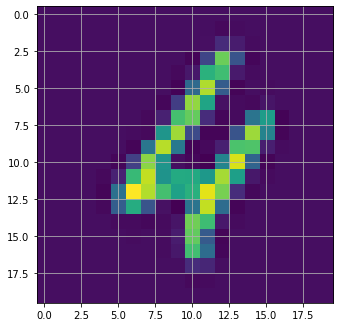

6 [4.]


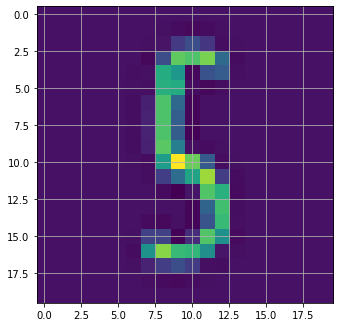

8 [5.]


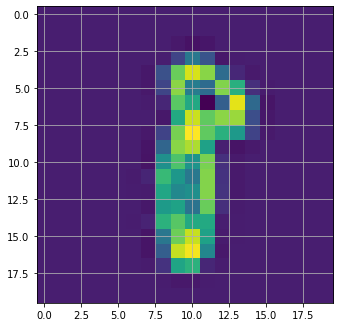

1 [8.]


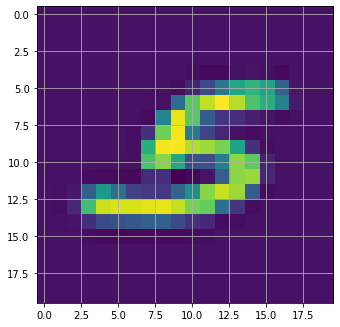

10 [5.]


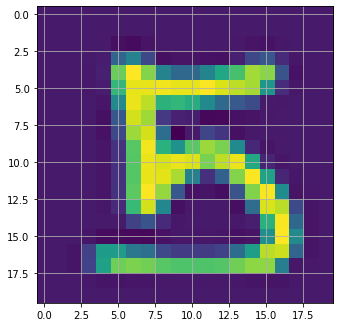

3 [5.]


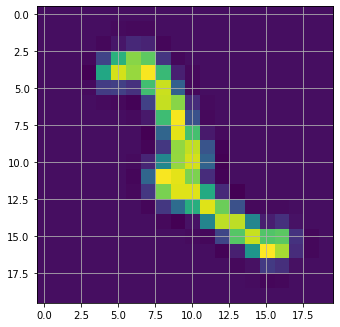

1 [2.]


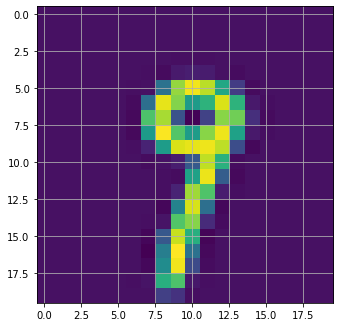

7 [9.]


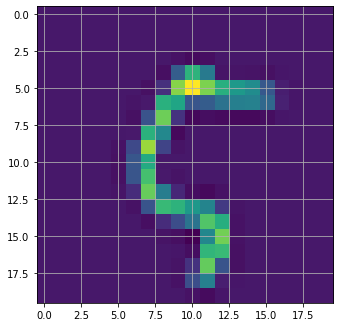

9 [5.]


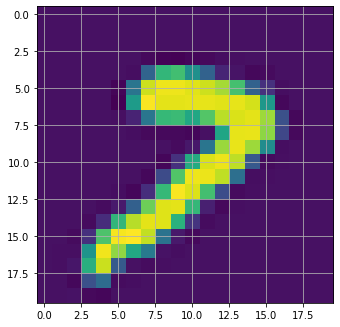

2 [7.]


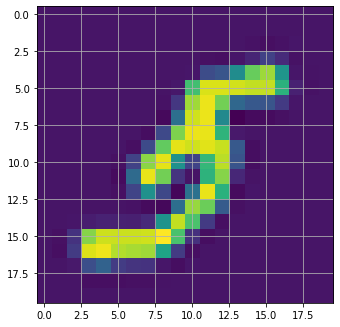

8 [5.]


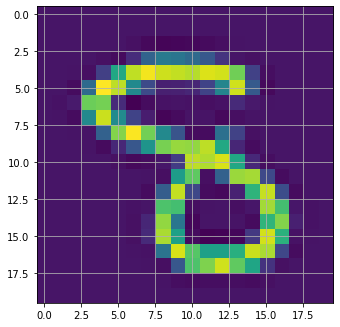

5 [8.]


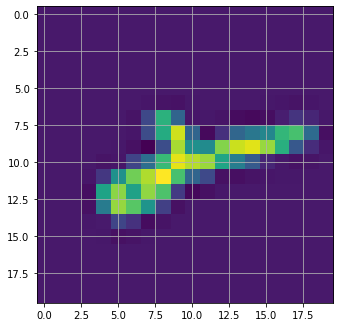

4 [2.]


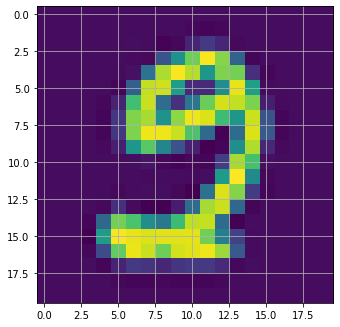

3 [2.]


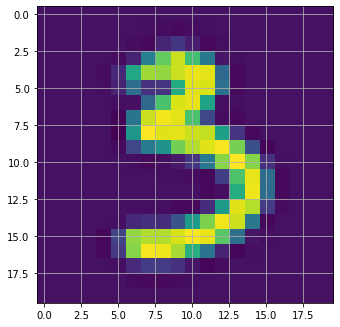

5 [3.]


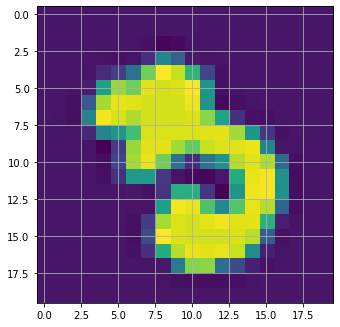

5 [3.]


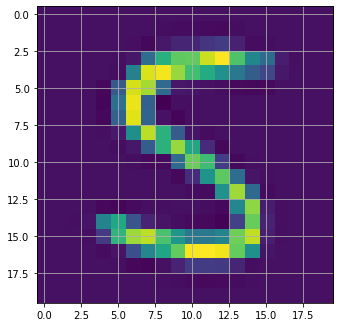

8 [5.]


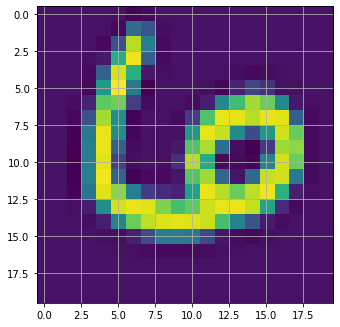

10 [6.]


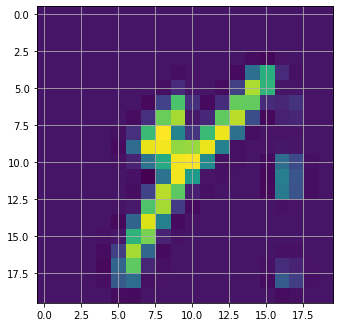

1 [4.]


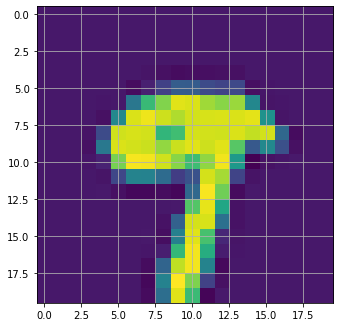

7 [9.]


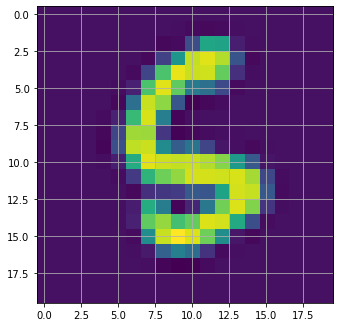

6 [5.]


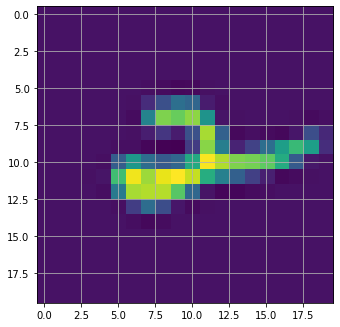

4 [2.]


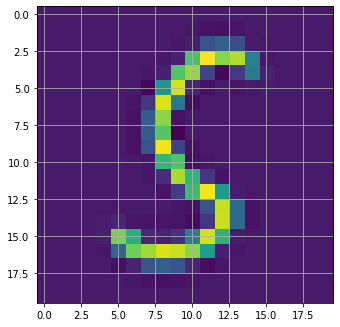

8 [5.]


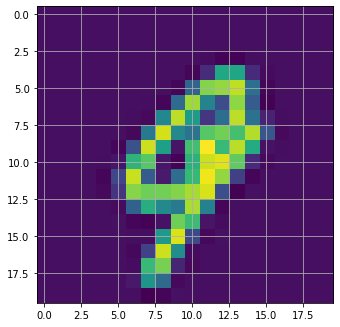

4 [9.]


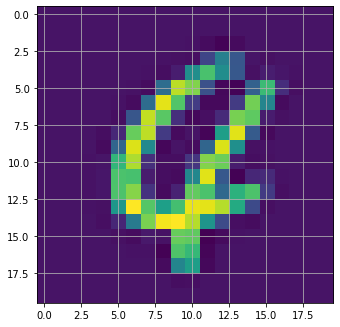

6 [4.]


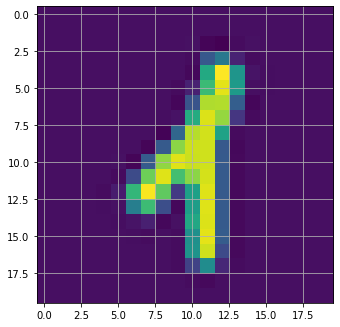

8 [1.]


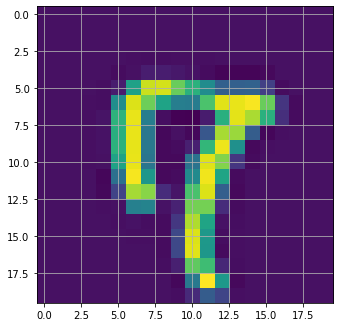

9 [7.]


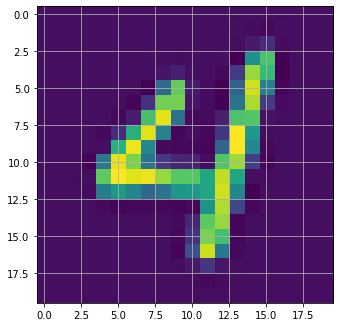

9 [4.]


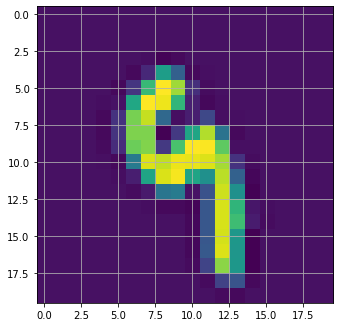

4 [9.]


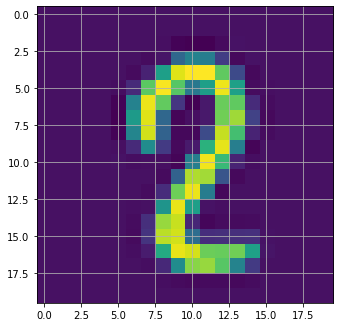

8 [2.]


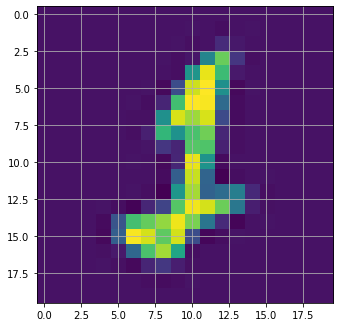

1 [2.]


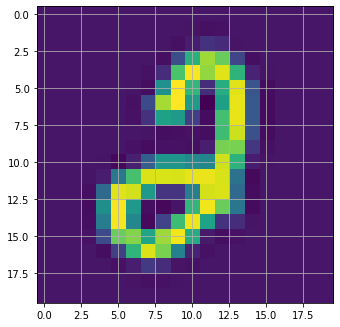

3 [2.]


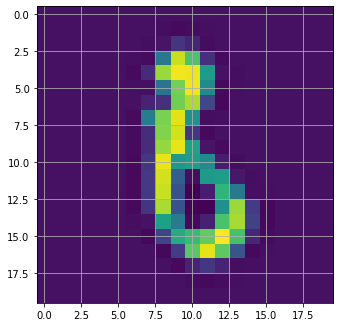

6 [8.]


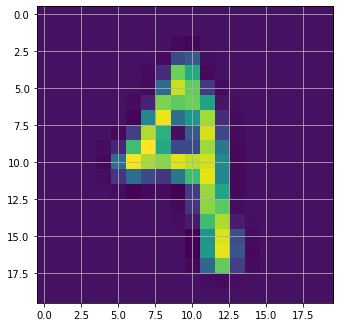

9 [4.]


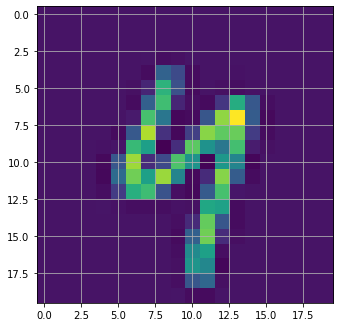

9 [4.]


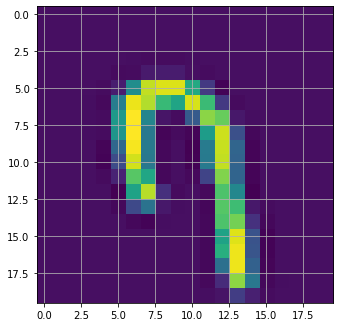

9 [7.]


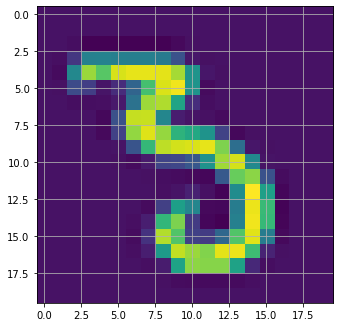

5 [3.]


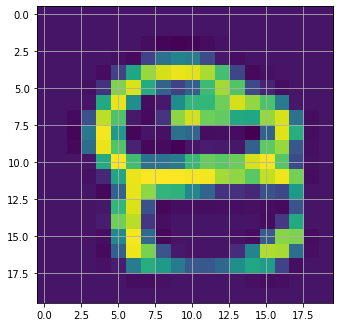

4 [8.]


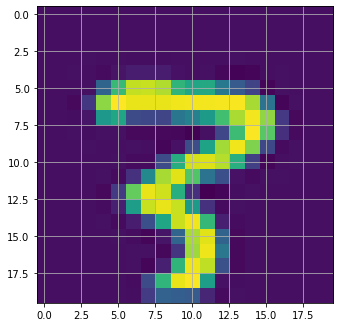

7 [3.]


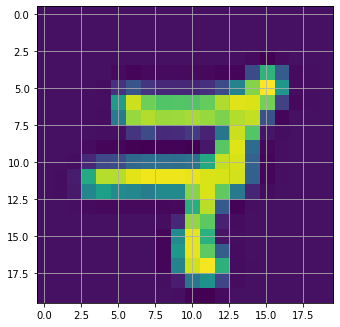

4 [7.]


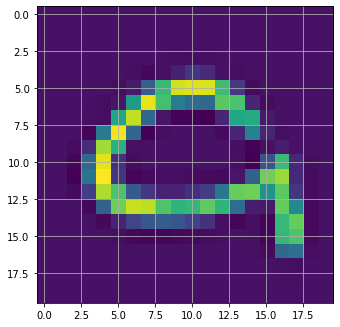

10 [9.]


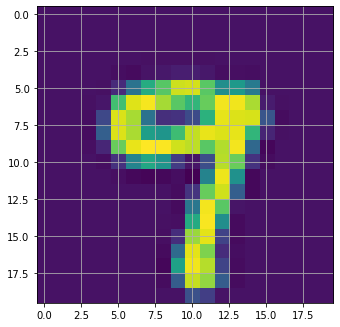

7 [9.]


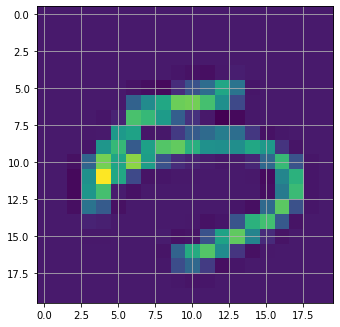

10 [5.]


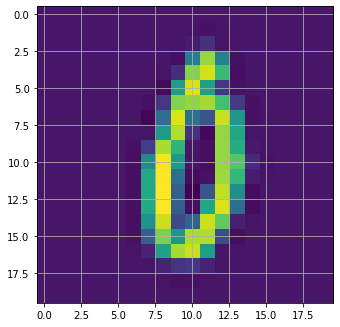

6 [10.]


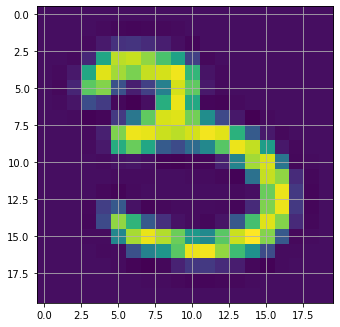

5 [3.]


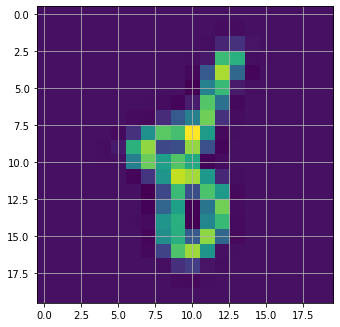

1 [8.]


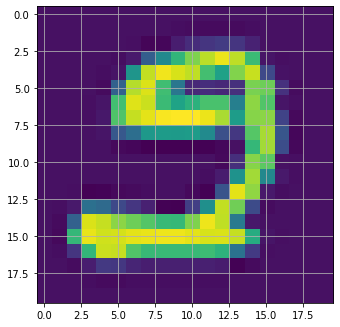

10 [2.]


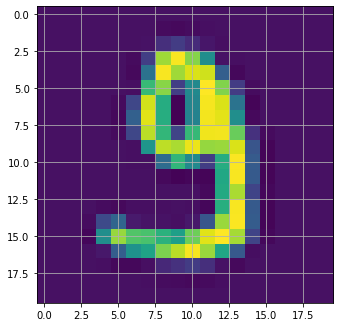

3 [9.]


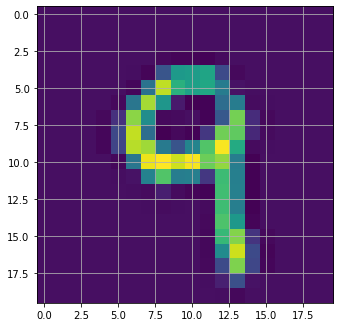

4 [9.]


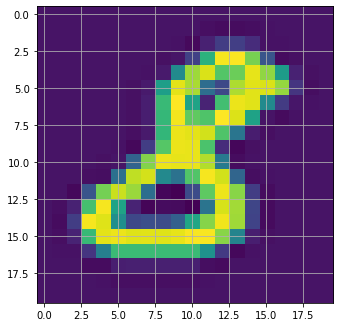

3 [8.]
82


In [352]:
Classifications=[]
#print(np.dot(Us[0][1],Us[0][1]))

for i in range(1000):
    Classifications.append(classify_y(Us,test_set[i],5)) 
Classifications=np.asarray(Classifications).astype(int)

incorrect_samples=0

for i in range(1000):
    #print(Classifications[i],test_labels[i])
    if Classifications[i]!=test_labels[i]:
        print_digit(test_set[i])
        print(Classifications[i],test_labels[i])
        incorrect_samples=incorrect_samples+1
print(incorrect_samples)